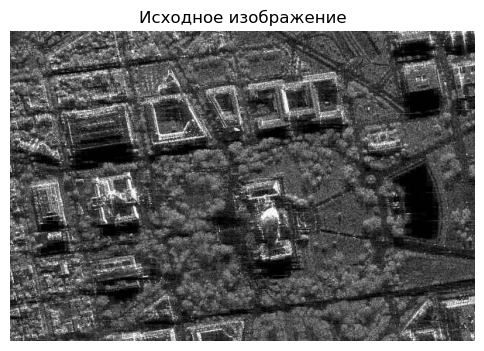

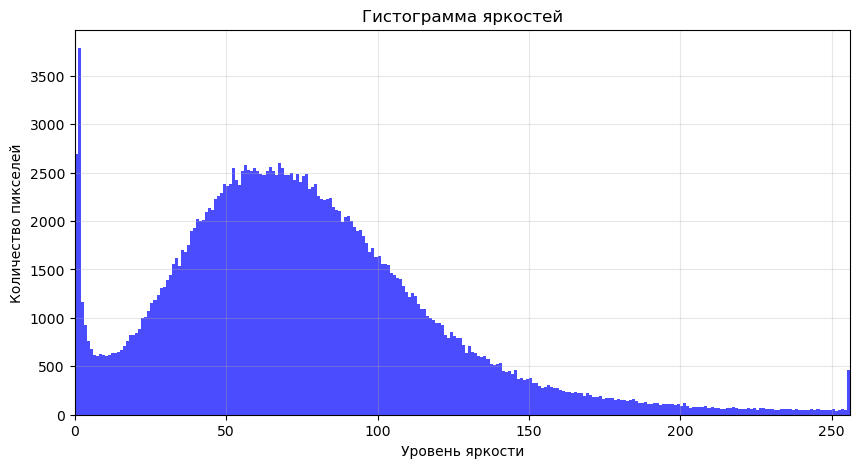

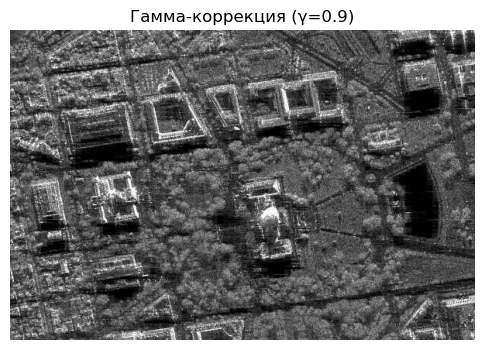

γ=0.9: MSE=65.61, SSIM=0.9912


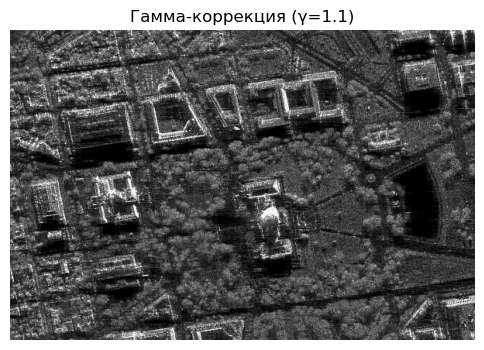

γ=1.1: MSE=64.54, SSIM=0.9869


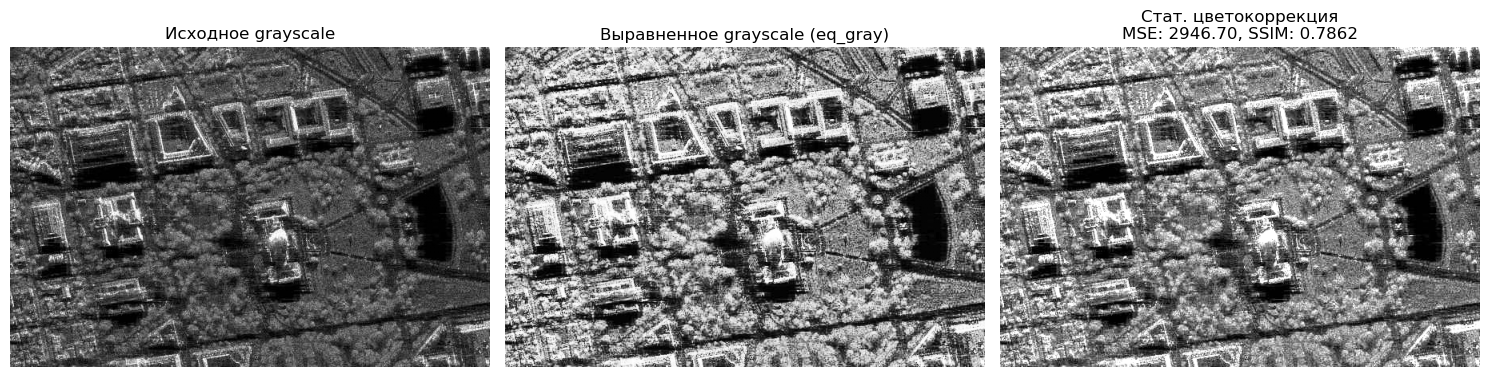

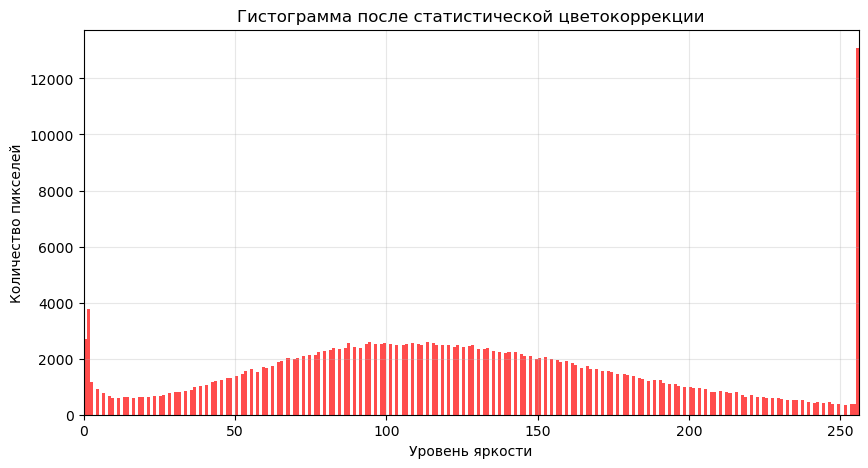

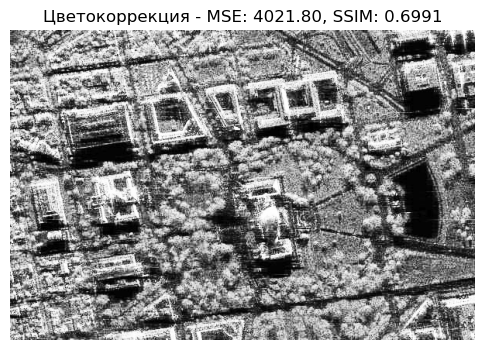

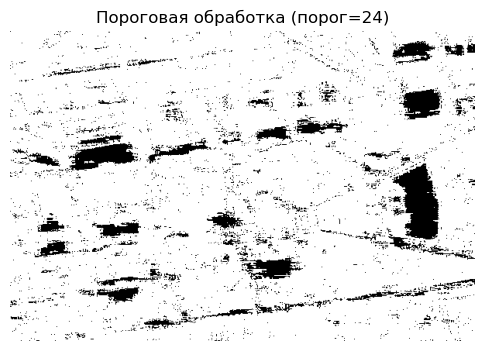

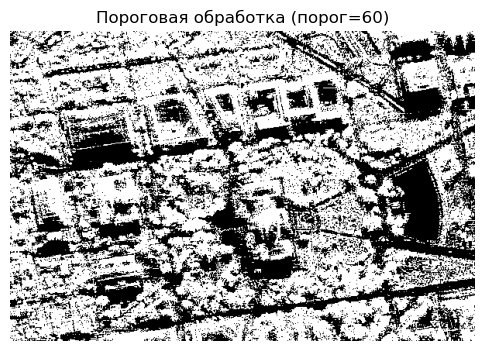

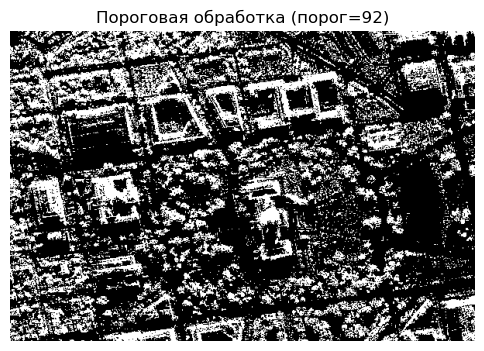

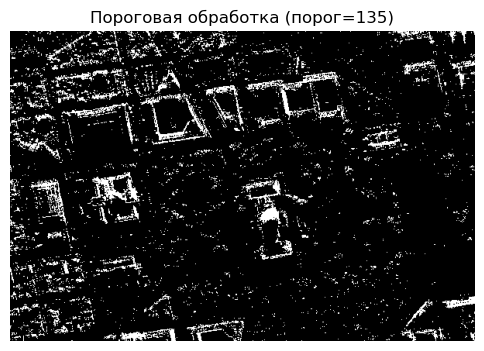

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# Основные функции обработки
def adjust_gamma(img, gamma_val):
    normalized = img / 255.0
    gamma_adjusted = np.power(normalized, gamma_val)
    return np.uint8(gamma_adjusted * 255)

def compute_difference(img1, img2):
    mse_result = compute_mse(img1, img2)
    ssim_result = ssim(img1, img2, multichannel=False)
    return mse_result, ssim_result

def compute_mse(img_original, img_processed):
    squared_diff = np.sum((img_original.astype("float") - img_processed.astype("float")) ** 2)
    return squared_diff / float(img_original.shape[0] * img_original.shape[1])

def enhance_colors(img):
    gray_version = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_equalized = cv2.equalizeHist(gray_version)
    
    blue_ch, green_ch, red_ch = cv2.split(img)
    blue_eq = cv2.equalizeHist(blue_ch)
    green_eq = cv2.equalizeHist(green_ch)
    red_eq = cv2.equalizeHist(red_ch)
    
    return cv2.merge((blue_eq, green_eq, red_eq))

def apply_threshold(img, thresh_val):
    _, binary_result = cv2.threshold(img, thresh_val, 255, cv2.THRESH_BINARY)
    return binary_result

# Статистическая цветокоррекция на основе статистики eq_gray
def statistical_color_correction(img):
    # Конвертируем в grayscale для получения статистики
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Вычисляем статистику для исходного изображения
    mean_original = np.mean(gray_img)
    std_original = np.std(gray_img)
    
    # Применяем гистограммное выравнивание к grayscale версии
    eq_gray = cv2.equalizeHist(gray_img)
    
    # Вычисляем статистику для выравненного изображения
    mean_target = np.mean(eq_gray)
    std_target = np.std(eq_gray)
    
    # Применяем линейное преобразование к каждому каналу
    blue_ch, green_ch, red_ch = cv2.split(img)
    
    # Корректируем каждый канал на основе статистики
    blue_corrected = ((blue_ch.astype(float) - mean_original) * (std_target / std_original)) + mean_target
    green_corrected = ((green_ch.astype(float) - mean_original) * (std_target / std_original)) + mean_target
    red_corrected = ((red_ch.astype(float) - mean_original) * (std_target / std_original)) + mean_target
    
    # Ограничиваем значения в диапазоне [0, 255] и конвертируем обратно
    blue_corrected = np.clip(blue_corrected, 0, 255).astype(np.uint8)
    green_corrected = np.clip(green_corrected, 0, 255).astype(np.uint8)
    red_corrected = np.clip(red_corrected, 0, 255).astype(np.uint8)
    
    # Объединяем каналы обратно
    corrected_img = cv2.merge((blue_corrected, green_corrected, red_corrected))
    
    return corrected_img, eq_gray

# Основная программа
def main():
    # Загрузка и подготовка изображения
    img_file = 'sar_1_gray.jpg'  
    original_img = cv2.imread(img_file)
    
    if original_img is None:
        print("Ошибка загрузки изображения!")
        return
    
    grayscale_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

    # Визуализация исходных данных
    plt.figure(figsize=(6, 6))
    plt.imshow(grayscale_img, cmap='gray')
    plt.title('Исходное изображение')
    plt.axis('off')
    plt.show()

    # Гистограмма распределения яркостей
    plt.figure(figsize=(10, 5))
    plt.hist(grayscale_img.ravel(), bins=256, range=[0, 256], color='blue', alpha=0.7)
    plt.title('Гистограмма яркостей')
    plt.xlabel('Уровень яркости')
    plt.ylabel('Количество пикселей')
    plt.xlim([0, 256])
    plt.grid(True, alpha=0.3)
    plt.show()

    # Тестирование гамма-коррекции
    gamma_params = [0.9, 1.1]  

    for gamma_param in gamma_params:
        gamma_img = adjust_gamma(grayscale_img, gamma_param)
        
        plt.figure(figsize=(6, 6))
        plt.imshow(gamma_img, cmap='gray')
        plt.title(f'Гамма-коррекция (γ={gamma_param})')
        plt.axis('off')
        plt.show()
        
        mse_score, ssim_score = compute_difference(grayscale_img, gamma_img)
        print(f'γ={gamma_param}: MSE={mse_score:.2f}, SSIM={ssim_score:.4f}')

    # Применение статистической цветокоррекции
    stat_corrected_img, eq_gray = statistical_color_correction(original_img)
    stat_corrected_gray = cv2.cvtColor(stat_corrected_img, cv2.COLOR_BGR2GRAY)

    mse_stat, ssim_stat = compute_difference(grayscale_img, stat_corrected_gray)

    # Визуализация результатов статистической цветокоррекции
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(grayscale_img, cmap='gray')
    plt.title('Исходное grayscale')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(eq_gray, cmap='gray')
    plt.title('Выравненное grayscale (eq_gray)')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(stat_corrected_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Стат. цветокоррекция\nMSE: {mse_stat:.2f}, SSIM: {ssim_stat:.4f}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    # Гистограмма после статистической цветокоррекции
    plt.figure(figsize=(10, 5))
    plt.hist(stat_corrected_gray.ravel(), bins=256, range=[0, 256], color='red', alpha=0.7)
    plt.title('Гистограмма после статистической цветокоррекции')
    plt.xlabel('Уровень яркости')
    plt.ylabel('Количество пикселей')
    plt.xlim([0, 256])
    plt.grid(True, alpha=0.3)
    plt.show()

    # Применение цветокоррекции (оригинальный метод)
    color_enhanced = enhance_colors(original_img)
    gray_enhanced = cv2.cvtColor(color_enhanced, cv2.COLOR_BGR2GRAY)

    mse_color, ssim_color = compute_difference(grayscale_img, gray_enhanced)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(color_enhanced, cv2.COLOR_BGR2RGB))
    plt.title(f'Цветокоррекция - MSE: {mse_color:.2f}, SSIM: {ssim_color:.4f}')
    plt.axis('off')
    plt.show()

    # Тестирование пороговой фильтрации
    threshold_values = [24, 60, 92, 135]

    for thresh in threshold_values:
        thresholded_img = apply_threshold(grayscale_img, thresh)
        plt.figure(figsize=(6, 6))
        plt.imshow(thresholded_img, cmap='gray')
        plt.title(f'Пороговая обработка (порог={thresh})')
        plt.axis('off')
        plt.show()

if __name__ == "__main__":
    main()